# CNN trained with data augmentation on the fly

l'augmentaion des données se fait dans le bacth pour avoir un modèle qui optimize des features non dépendantes du numéro d'échantillon

on applique donc un décalage temporel de l'ensemble du signal. la décalage est au maximum le nombre d'échantillons de zero padding on applique aussi un léger filtre gaussien, léger car les pics de faibles largeurs sont fortement impactés.

In [1]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim
from sklearn.model_selection import train_test_split
import joblib

In [8]:
from tqdm.notebook import tqdm

In [7]:
from scipy import ndimage
import  seaborn as sns

## MODEL

In [4]:
def timeshiftsignal(X_batch):
    n_zeros_pad = ((X_batch.flip(dims=[2])!=0)).to(float).argmax(dim=2)
    n_zeros_pad = n_zeros_pad.detach().numpy().flatten()
    
    n_shift = X_batch.shape[0]
    n_apply_shift = np.random.randint(n_shift)
    if n_apply_shift>1:
        index_apply_shift = list(range(X_batch.shape[0]))
        np.random.shuffle(index_apply_shift)
        ii_shift = index_apply_shift[0:n_shift]
 
        for ii in ii_shift:
            if n_zeros_pad[ii]>0:
                X_batch[ii,:,:] = X_batch[ii,:,:].roll(np.random.randint(n_zeros_pad[ii]),dims=[1])

    return X_batch

In [5]:
def fly_shift_and_gauss(X_batch,Gau,n_Gauss=None,n_shift=None):
    with torch.no_grad():
        n_zeros_pad = ((X_batch.flip(dims=[2])!=0)).to(float).argmax(dim=2)
        n_zeros_pad = n_zeros_pad.detach().numpy().flatten()
        if n_Gauss is None:
            n_Gauss = X_batch.shape[0]
        if n_shift is None:
            n_shift = X_batch.shape[0]
        # apply gaussian filter randomnly to N signal
        # N must be at least the number of gussian filters defined : 3
        n_apply_gauss = X_batch.shape[0] //2 #np.random.randint(n_Gauss)
        # number of gaussian filter to apply
        n_filter_gauss = len(Gau)
        #if n_apply_gauss>=n_filter_gauss:
        index_apply_gauss = list(range(X_batch.shape[0]))
        np.random.shuffle(index_apply_gauss)
        # apply eahc gaussian to a part of the N signals 
        gn = int(n_apply_gauss/n_filter_gauss) # number of signals filtered by 1 gaussian
        for kg in range(n_filter_gauss):              
            ii_gauss = index_apply_gauss[kg*gn:(kg+1)*gn]        
            X_batch[ii_gauss,:,:] =  Gau[kg](X_batch[ii_gauss,:,:])

        n_apply_shift = X_batch.shape[0] //2 #np.random.randint(n_shift)
        #if n_apply_shift>1:
        index_apply_shift = list(range(X_batch.shape[0]))
        np.random.shuffle(index_apply_shift)
        ii_shift = index_apply_shift[0:n_shift]
     
        for ii in ii_shift:
            if n_zeros_pad[ii]>0:
                X_batch[ii,:,:] = X_batch[ii,:,:].roll(np.random.randint(n_zeros_pad[ii]),dims=[1])
    return X_batch

In [6]:
Gau = []
with torch.no_grad():
    for sigma in [0.5,0.7]:
        weights = ndimage._filters._gaussian_kernel1d(sigma, 0, int(4 * sigma + 0.5))[::-1]
        conv = nn.Conv1d(1, 1, weights.shape[0], stride=1, padding='same',bias=False)
        for k in range(conv.weight.shape[2]):
            conv.weight[0,0,k]= torch.tensor(weights[k])
        Gau.append(conv)

In [3]:
def evaluate_model(model, test_set):
    X, y_true = test_set[:]
   
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    
    with torch.no_grad():
        # Prédiction du modèle pour un batch donné
        y_pred = model(X)

    loss_test = criterion(y_pred, y_true)
    
    y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
    y_true = y_true.numpy()
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test.item()
    
def train_a_model(model,train_loader,Gau,test_set,epochs = 100,lr=1e-3,device='cpu',outmodelname=None):


  
    
    best_accuracy = 0
    optimizer = optim.Adam(model.parameters(), lr)

       # Définir le scheduler ReduceLROnPlateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    mode='min',
                                                    factor=0.5,
                                                    patience=5,
                                                    verbose=True)
    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    loss_list_test = []

    accuracy_list = []
    start = time.time()
    
    for epoch in range(epochs):
        progress_bar = tqdm(
            train_loader, desc="train", leave=True, disable=False
        )
        # Dans ce mode certaines couches du modèle agissent différemment
        model.train()
        loss_total = 0
        
        for i, batch in enumerate(progress_bar):
            # Batch de données
            X_batch, y_batch = batch

            X_batch = fly_shift_and_gauss(X_batch,Gau)

            
            # Device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Gradient mis 0
            model.zero_grad()
    
            # Calcul de prédiction
            y_pred = model(X_batch)
    
            # Calcul de la fonction de perte
            loss = criterion(y_pred, y_batch)
    
            # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
            loss.backward()
            
            # Clipper le gradient entre 0 et 1 pour plus de stabilité
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Descente de gradient : actualisation des paramètres
            optimizer.step()
            
            loss_total += loss.item()
            
        scheduler.step(loss_total/len(train_loader))

        
        y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
        if accuracy > best_accuracy and outmodelname is not None:
            joblib.dump(model, outmodelname)
            print('save model')
            best_accuracy = accuracy
        loss_list.append(loss_total/len(train_loader))
        loss_list_test.append(loss)
        accuracy_list.append(accuracy)
        print(f"Epoch : {epoch+1}/{epochs} -- Training loss {loss_total/len(train_loader)}, --- Val loss {loss}, --- accuray : {accuracy}, --- recall : {recall}")
    
    end = time.time()
    
    print("execution time: ",end - start)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss_list,label='loss train')
    ax.plot(loss_list_test,label='loss test')
    ax.legend()

    table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
    print(table)

    print(classification_report(y_true, y_pred))

In [8]:
def mycnn(input_shape=187,device='cpu',dropout=0.4):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=80, kernel_size=5, stride=1, padding=0), # shape: (batch_size, n, 183)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 91)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 89)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 44)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 42)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 21)
        
        nn.Flatten() , # shape: (batch_size, 10*n)
        nn.Dropout(dropout),
        nn.Linear(21*80, 50),
        nn.ReLU(),
        nn.Linear(50, 5),
         #nn.Softmax(dim=-1)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
   

In [9]:
epochs = 250

In [5]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')
X_train,X_cross, y_train, y_cross = train_test_split(X_train,y_train,test_size=0.15,random_state=12)

X_train =np.expand_dims(X_train,axis=1)
X_cross =np.expand_dims(X_cross,axis=1)

print(X_train.shape)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

X_valid, y_valid = load_balanced.load('../data/raw/mitbih_test.csv')
X_valid =np.expand_dims(X_valid,axis=1)

valid_set =  TensorDataset(torch.from_numpy(X_valid).float(), torch.Tensor(torch.from_numpy(y_valid).long()))

(212500, 1, 187)


## train

In [13]:
model = mycnn()

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            480
├─ReLU: 1-2                              --
├─BatchNorm1d: 1-3                       160
├─MaxPool1d: 1-4                         --
├─Conv1d: 1-5                            19,280
├─ReLU: 1-6                              --
├─BatchNorm1d: 1-7                       160
├─MaxPool1d: 1-8                         --
├─Conv1d: 1-9                            19,280
├─ReLU: 1-10                             --
├─BatchNorm1d: 1-11                      160
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Dropout: 1-14                          --
├─Linear: 1-15                           84,050
├─ReLU: 1-16                             --
├─Linear: 1-17                           255
Total params: 123,825
Trainable params: 123,825
Non-trainable params: 0


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 1/250 -- Training loss 0.3160326231998556, --- Val loss 0.25382453203201294, --- accuray : 0.9129994174928656, --- recall : 0.9095008893093531


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 2/250 -- Training loss 0.18481198825730996, --- Val loss 0.195648655295372, --- accuray : 0.9335898476207939, --- recall : 0.9323107889391554


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 3/250 -- Training loss 0.15523707421912866, --- Val loss 0.1590559184551239, --- accuray : 0.9462681390674978, --- recall : 0.9444714681002037


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 4/250 -- Training loss 0.1378230723572128, --- Val loss 0.14816270768642426, --- accuray : 0.949603080777314, --- recall : 0.946839333438237


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 5/250 -- Training loss 0.12581846784493503, --- Val loss 0.1378968060016632, --- accuray : 0.9512869232833067, --- recall : 0.9495795262225277


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 6/250 -- Training loss 0.11665914515055278, --- Val loss 0.12677961587905884, --- accuray : 0.9565662353136789, --- recall : 0.9548912690999252


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 7/250 -- Training loss 0.1101668659387266, --- Val loss 0.10971120744943619, --- accuray : 0.9612545147117796, --- recall : 0.9604276757976301


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 8/250 -- Training loss 0.1046448704839191, --- Val loss 0.10562048107385635, --- accuray : 0.9626225561743894, --- recall : 0.9626023027208845


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 9/250 -- Training loss 0.09986687397518579, --- Val loss 0.10521386563777924, --- accuray : 0.9641571754875196, --- recall : 0.9640711360874639


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 10/250 -- Training loss 0.0953617025999462, --- Val loss 0.09751547873020172, --- accuray : 0.968357512415521, --- recall : 0.967976485489087


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 11/250 -- Training loss 0.09234080873692736, --- Val loss 0.10080017894506454, --- accuray : 0.9657632564870295, --- recall : 0.9649651744104923


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 12/250 -- Training loss 0.08938513125260086, --- Val loss 0.11073216050863266, --- accuray : 0.962630290312853, --- recall : 0.9614456229003159


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 13/250 -- Training loss 0.08704575616734869, --- Val loss 0.11442190408706665, --- accuray : 0.9601084658327043, --- recall : 0.9574580170329637


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 14/250 -- Training loss 0.08421002432594404, --- Val loss 0.07942652702331543, --- accuray : 0.9723786891134687, --- recall : 0.9719302849621968


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 15/250 -- Training loss 0.0823737677839749, --- Val loss 0.09054400026798248, --- accuray : 0.9689042659924935, --- recall : 0.9681348421090787


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 16/250 -- Training loss 0.07990275575921817, --- Val loss 0.09013757854700089, --- accuray : 0.96835635812321, --- recall : 0.9680003873255837


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 17/250 -- Training loss 0.07810517481320045, --- Val loss 0.0887475460767746, --- accuray : 0.9702133843088744, --- recall : 0.9691081187820659


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 18/250 -- Training loss 0.07661780640899259, --- Val loss 0.08388592302799225, --- accuray : 0.9702844527964499, --- recall : 0.9697036403034269


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 19/250 -- Training loss 0.07464532939574736, --- Val loss 0.07820142805576324, --- accuray : 0.9738135750713776, --- recall : 0.9736556409691246


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 20/250 -- Training loss 0.07254438154530876, --- Val loss 0.07123346626758575, --- accuray : 0.9762365474719953, --- recall : 0.9760936524682255


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 21/250 -- Training loss 0.07218861497741412, --- Val loss 0.08591683954000473, --- accuray : 0.9722063236825413, --- recall : 0.9717049174849246


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 22/250 -- Training loss 0.07119095023064052, --- Val loss 0.07058271020650864, --- accuray : 0.9757408388352553, --- recall : 0.9755875646689892


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 23/250 -- Training loss 0.06881508983211482, --- Val loss 0.0771147608757019, --- accuray : 0.9746577978164895, --- recall : 0.9740573200617902


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 24/250 -- Training loss 0.0680704967322595, --- Val loss 0.06496939063072205, --- accuray : 0.9776068565025927, --- recall : 0.9772433152938167


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 25/250 -- Training loss 0.06679105279046824, --- Val loss 0.0951763242483139, --- accuray : 0.9687562716263596, --- recall : 0.9669205503138946


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 26/250 -- Training loss 0.06617635058545891, --- Val loss 0.06976572424173355, --- accuray : 0.9759331300427478, --- recall : 0.9758949487971019


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 27/250 -- Training loss 0.06448576924993711, --- Val loss 0.08159291744232178, --- accuray : 0.9709017559239216, --- recall : 0.9703525876079425


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 28/250 -- Training loss 0.06522912065925844, --- Val loss 0.07596419006586075, --- accuray : 0.9742693619806648, --- recall : 0.9736450295639065


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 29/250 -- Training loss 0.06285424748008304, --- Val loss 0.06093050166964531, --- accuray : 0.9794647247613089, --- recall : 0.9793220357440072


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 30/250 -- Training loss 0.061788991719922595, --- Val loss 0.06262093037366867, --- accuray : 0.979600426048697, --- recall : 0.9795546633276903


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 31/250 -- Training loss 0.062095845051164576, --- Val loss 0.06335628777742386, --- accuray : 0.9792111570731642, --- recall : 0.9790115614754991


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 32/250 -- Training loss 0.06161365363538703, --- Val loss 0.06446763873100281, --- accuray : 0.9788822712543939, --- recall : 0.978646250747067


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 33/250 -- Training loss 0.05968178970476284, --- Val loss 0.05997033789753914, --- accuray : 0.9796385425678669, --- recall : 0.9795183584279841


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 34/250 -- Training loss 0.059182131736703655, --- Val loss 0.08013463020324707, --- accuray : 0.9718429590287337, --- recall : 0.9706075802253789


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 35/250 -- Training loss 0.05856204954063629, --- Val loss 0.06024157628417015, --- accuray : 0.9797995551697589, --- recall : 0.9794606596360195


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 36/250 -- Training loss 0.058198402715408624, --- Val loss 0.058013979345560074, --- accuray : 0.9806975994287782, --- recall : 0.9805165297692845


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 37/250 -- Training loss 0.058502029633587777, --- Val loss 0.057637590914964676, --- accuray : 0.9805125840993837, --- recall : 0.980431573338618


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 38/250 -- Training loss 0.05607330894612653, --- Val loss 0.06096546724438667, --- accuray : 0.9795416206583942, --- recall : 0.979256124752618


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 39/250 -- Training loss 0.055346891311709494, --- Val loss 0.06882038712501526, --- accuray : 0.9778255504090829, --- recall : 0.9767846127247208


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 40/250 -- Training loss 0.05634252493346439, --- Val loss 0.05555815249681473, --- accuray : 0.9814767688606063, --- recall : 0.9811161609456468


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 41/250 -- Training loss 0.055546715272590516, --- Val loss 0.0544489361345768, --- accuray : 0.9812021402659796, --- recall : 0.9811623376794241


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 42/250 -- Training loss 0.05395814445012194, --- Val loss 0.05871167406439781, --- accuray : 0.9796981880224278, --- recall : 0.9795284916863144


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 43/250 -- Training loss 0.055172438392141726, --- Val loss 0.05620431527495384, --- accuray : 0.9810374805246246, --- recall : 0.9808134441070241


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 44/250 -- Training loss 0.053613954327671846, --- Val loss 0.06658973544836044, --- accuray : 0.9782406138565356, --- recall : 0.9779271955016172


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 45/250 -- Training loss 0.05290287415458656, --- Val loss 0.05285672843456268, --- accuray : 0.9826824761126076, --- recall : 0.9824976401384047


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 46/250 -- Training loss 0.05356835909532931, --- Val loss 0.053274769335985184, --- accuray : 0.9818371767150456, --- recall : 0.9816189263312856


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 47/250 -- Training loss 0.05337681326850811, --- Val loss 0.055855926126241684, --- accuray : 0.9814781937139598, --- recall : 0.9813336316880656


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 48/250 -- Training loss 0.05257941533329294, --- Val loss 0.05068887025117874, --- accuray : 0.9828646237516192, --- recall : 0.9826833998765754


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 49/250 -- Training loss 0.051278594292481154, --- Val loss 0.054235633462667465, --- accuray : 0.9820921849571272, --- recall : 0.9819212117400339


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 50/250 -- Training loss 0.05144166699753088, --- Val loss 0.048679884523153305, --- accuray : 0.9832278803724449, --- recall : 0.9831981552041938


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 51/250 -- Training loss 0.05080462990881985, --- Val loss 0.05122019723057747, --- accuray : 0.9825104328141375, --- recall : 0.9823489411062992


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 52/250 -- Training loss 0.05066652093225104, --- Val loss 0.050816167145967484, --- accuray : 0.9820940858143435, --- recall : 0.9820321034292215


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 53/250 -- Training loss 0.0512401321513907, --- Val loss 0.053776178508996964, --- accuray : 0.9812123400634445, --- recall : 0.9810868478206729


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 54/250 -- Training loss 0.04939022164906868, --- Val loss 0.05285976082086563, --- accuray : 0.9818498698440976, --- recall : 0.9815009930089225


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 55/250 -- Training loss 0.04892182604935678, --- Val loss 0.052693646401166916, --- accuray : 0.9820847390437912, --- recall : 0.9816799291284498


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 56/250 -- Training loss 0.049700794353916805, --- Val loss 0.049266017973423004, --- accuray : 0.9828267855898242, --- recall : 0.9826004801014225


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 57/250 -- Training loss 0.048747725653215584, --- Val loss 0.05151556804776192, --- accuray : 0.9825013986659983, --- recall : 0.9823669760614813


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 58/250 -- Training loss 0.04956247377187452, --- Val loss 0.0478055514395237, --- accuray : 0.9842082505382477, --- recall : 0.9841969895367633


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 59/250 -- Training loss 0.04786047535121222, --- Val loss 0.050937410444021225, --- accuray : 0.9830142522244565, --- recall : 0.9827925403710281


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 60/250 -- Training loss 0.04842023493837127, --- Val loss 0.04980356991291046, --- accuray : 0.982725794687789, --- recall : 0.9826227193115409


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 61/250 -- Training loss 0.046437983153826176, --- Val loss 0.0457654669880867, --- accuray : 0.9844296623655792, --- recall : 0.9844362898652232


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 62/250 -- Training loss 0.04775967800091295, --- Val loss 0.04842560365796089, --- accuray : 0.9840019147816685, --- recall : 0.9838129206858731


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 63/250 -- Training loss 0.047111548571025626, --- Val loss 0.046839695423841476, --- accuray : 0.9839036626165363, --- recall : 0.9838882397039879


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 64/250 -- Training loss 0.047379847433472816, --- Val loss 0.05518252030014992, --- accuray : 0.9805129335067881, --- recall : 0.9801697115325757


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 65/250 -- Training loss 0.04638982858174645, --- Val loss 0.044553060084581375, --- accuray : 0.9850794370427727, --- recall : 0.9849329207144206


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 66/250 -- Training loss 0.04555777946377502, --- Val loss 0.047872982919216156, --- accuray : 0.9835009507393659, --- recall : 0.9830869952144138


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 67/250 -- Training loss 0.04526610682647237, --- Val loss 0.04790526255965233, --- accuray : 0.9831439677309193, --- recall : 0.9827936231486273


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 68/250 -- Training loss 0.04645768738888642, --- Val loss 0.05545247346162796, --- accuray : 0.9801730419217105, --- recall : 0.9796236591432315


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 69/250 -- Training loss 0.04530203604490003, --- Val loss 0.04715830460190773, --- accuray : 0.9841682480734303, --- recall : 0.9836937736720006


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 70/250 -- Training loss 0.04557427853154128, --- Val loss 0.04486527293920517, --- accuray : 0.9852814464063678, --- recall : 0.9852109094413051


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 71/250 -- Training loss 0.04449599690483335, --- Val loss 0.05352015793323517, --- accuray : 0.9818809548694805, --- recall : 0.9818039646656824


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 72/250 -- Training loss 0.044621739642475455, --- Val loss 0.056518588215112686, --- accuray : 0.9805128550180605, --- recall : 0.9801271887152708


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 73/250 -- Training loss 0.0452537082526285, --- Val loss 0.04632130637764931, --- accuray : 0.9840015964498889, --- recall : 0.9838677806457536


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 74/250 -- Training loss 0.04495131628376925, --- Val loss 0.043093182146549225, --- accuray : 0.9848678886527136, --- recall : 0.9847818324886868


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 75/250 -- Training loss 0.04418032837555032, --- Val loss 0.0432666651904583, --- accuray : 0.9852332447039762, --- recall : 0.9850989950677747


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 76/250 -- Training loss 0.04322161615470096, --- Val loss 0.049706656485795975, --- accuray : 0.9830943520735207, --- recall : 0.9829616118174901


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 77/250 -- Training loss 0.044312083295436906, --- Val loss 0.04362114891409874, --- accuray : 0.985110721535654, --- recall : 0.984902801743732


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 78/250 -- Training loss 0.04214135303630439, --- Val loss 0.0443028062582016, --- accuray : 0.9847821024872584, --- recall : 0.9846757439234721


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 79/250 -- Training loss 0.04302997995233711, --- Val loss 0.0493343323469162, --- accuray : 0.9830307618809668, --- recall : 0.9827604217484189


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 80/250 -- Training loss 0.042689021978691656, --- Val loss 0.0461060032248497, --- accuray : 0.984459930601776, --- recall : 0.9844070165813296


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 81/250 -- Training loss 0.04413011826618629, --- Val loss 0.0419803187251091, --- accuray : 0.9855638621031302, --- recall : 0.9854127727050612


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 82/250 -- Training loss 0.04295209095484632, --- Val loss 0.04281538724899292, --- accuray : 0.9850720370551569, --- recall : 0.9849838164026975


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 83/250 -- Training loss 0.042219044054036634, --- Val loss 0.04747185483574867, --- accuray : 0.9848104189994868, --- recall : 0.9847415633128197


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 84/250 -- Training loss 0.043147545609623195, --- Val loss 0.04043760523200035, --- accuray : 0.9868273054041745, --- recall : 0.9867946915557353


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 85/250 -- Training loss 0.0372534233702018, --- Val loss 0.036963362246751785, --- accuray : 0.9869076979947528, --- recall : 0.9868057746412842


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 86/250 -- Training loss 0.036014405952602184, --- Val loss 0.038332656025886536, --- accuray : 0.9870567800035481, --- recall : 0.9870202022140899


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 87/250 -- Training loss 0.03441972747351974, --- Val loss 0.03659961000084877, --- accuray : 0.9878759319350227, --- recall : 0.9877894694554813


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 88/250 -- Training loss 0.033450128138722744, --- Val loss 0.036078836768865585, --- accuray : 0.9871182824156893, --- recall : 0.9870729117296161


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 89/250 -- Training loss 0.03349663678430678, --- Val loss 0.035301573574543, --- accuray : 0.9882567156815287, --- recall : 0.9882719508639362


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 90/250 -- Training loss 0.03438435459117788, --- Val loss 0.03261342644691467, --- accuray : 0.9891832187469337, --- recall : 0.9891695827302037


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 91/250 -- Training loss 0.03299370826533585, --- Val loss 0.03578873351216316, --- accuray : 0.9875372876800796, --- recall : 0.9873838246754177


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 92/250 -- Training loss 0.03342531293427901, --- Val loss 0.03372320160269737, --- accuray : 0.9889319234722285, --- recall : 0.9889431182942149


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 93/250 -- Training loss 0.03265720787466339, --- Val loss 0.032942336052656174, --- accuray : 0.9883895122490465, --- recall : 0.9883339797190706


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 94/250 -- Training loss 0.032992865725831294, --- Val loss 0.03589488938450813, --- accuray : 0.9872696983108051, --- recall : 0.9872484548120182


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 95/250 -- Training loss 0.03254049173475462, --- Val loss 0.03496592864394188, --- accuray : 0.988215848126265, --- recall : 0.9882175065275252


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 96/250 -- Training loss 0.032260705455302206, --- Val loss 0.03596067056059837, --- accuray : 0.9880949338775398, --- recall : 0.9880466870912045


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 97/250 -- Training loss 0.03226792854245971, --- Val loss 0.03701367229223251, --- accuray : 0.9872812222106375, --- recall : 0.9871888589646911


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 98/250 -- Training loss 0.032529663024305856, --- Val loss 0.033051930367946625, --- accuray : 0.9888079254429449, --- recall : 0.9887230072363107


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 99/250 -- Training loss 0.0322279738489648, --- Val loss 0.03351913392543793, --- accuray : 0.9885328087970979, --- recall : 0.9884332335181863


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 100/250 -- Training loss 0.031959362101261775, --- Val loss 0.03370339423418045, --- accuray : 0.9882942880240438, --- recall : 0.9882504302193938


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 101/250 -- Training loss 0.031870638943195126, --- Val loss 0.036385148763656616, --- accuray : 0.9879403455708073, --- recall : 0.9879218876791853


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 102/250 -- Training loss 0.031468728428891424, --- Val loss 0.03233290836215019, --- accuray : 0.9893539621723217, --- recall : 0.9893596270146299


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 103/250 -- Training loss 0.03164239612134064, --- Val loss 0.03404930233955383, --- accuray : 0.9883373650841516, --- recall : 0.9882493144749743


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 104/250 -- Training loss 0.0315270811205949, --- Val loss 0.03164628520607948, --- accuray : 0.9895402425924675, --- recall : 0.9895176903685616


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 105/250 -- Training loss 0.03098959136376267, --- Val loss 0.032232243567705154, --- accuray : 0.9886740071326738, --- recall : 0.9885939214664214


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 106/250 -- Training loss 0.030818774483207724, --- Val loss 0.03269436955451965, --- accuray : 0.988861952019308, --- recall : 0.9888552249632669


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 107/250 -- Training loss 0.03141713843683657, --- Val loss 0.030868910253047943, --- accuray : 0.9894658483389179, --- recall : 0.9894341755426425


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 108/250 -- Training loss 0.03235900074909167, --- Val loss 0.030325807631015778, --- accuray : 0.9899042822192543, --- recall : 0.9898927520718118


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 109/250 -- Training loss 0.03108197539817432, --- Val loss 0.03193361312150955, --- accuray : 0.9889563980572534, --- recall : 0.9888870063690826


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 110/250 -- Training loss 0.03095558902692488, --- Val loss 0.034010641276836395, --- accuray : 0.9884730014055529, --- recall : 0.9884151858116047


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 111/250 -- Training loss 0.030765567555064884, --- Val loss 0.034701209515333176, --- accuray : 0.988216379668781, --- recall : 0.9881170373718821


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 112/250 -- Training loss 0.032600767572506274, --- Val loss 0.032289791852235794, --- accuray : 0.9892020174488698, --- recall : 0.9891628217070794


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 113/250 -- Training loss 0.03146437384221045, --- Val loss 0.03498624637722969, --- accuray : 0.9878481472908079, --- recall : 0.9877029896170466


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 114/250 -- Training loss 0.03190189884340062, --- Val loss 0.032519061118364334, --- accuray : 0.9890936423944552, --- recall : 0.9890591941438787


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 115/250 -- Training loss 0.030107733090955983, --- Val loss 0.031495288014411926, --- accuray : 0.9889773975591831, --- recall : 0.9889588807662676


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 116/250 -- Training loss 0.030767358625061154, --- Val loss 0.032005179673433304, --- accuray : 0.9890610952509059, --- recall : 0.9890383637621829


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 117/250 -- Training loss 0.030173508828396305, --- Val loss 0.032620735466480255, --- accuray : 0.9884480631076974, --- recall : 0.9883479317466508


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 118/250 -- Training loss 0.030151395613519365, --- Val loss 0.033214498311281204, --- accuray : 0.9889437338928337, --- recall : 0.988864303615349


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 119/250 -- Training loss 0.030842319051803582, --- Val loss 0.030817532911896706, --- accuray : 0.9898065602601658, --- recall : 0.9897802595121854


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 120/250 -- Training loss 0.030413033922011144, --- Val loss 0.03116203472018242, --- accuray : 0.9894419164767806, --- recall : 0.9894382431040739


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 121/250 -- Training loss 0.030180101844646475, --- Val loss 0.02990715764462948, --- accuray : 0.9903440054788957, --- recall : 0.990308216783542


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 122/250 -- Training loss 0.028680151654188246, --- Val loss 0.02888958714902401, --- accuray : 0.9905088786743612, --- recall : 0.9904749744706016


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 123/250 -- Training loss 0.02766246135634206, --- Val loss 0.029489202424883842, --- accuray : 0.9903537289944637, --- recall : 0.9903436514353583


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 124/250 -- Training loss 0.02646052434143391, --- Val loss 0.02883194386959076, --- accuray : 0.990142742311226, --- recall : 0.9901310836290538


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 125/250 -- Training loss 0.026675112127066206, --- Val loss 0.029178300872445107, --- accuray : 0.9900719901638745, --- recall : 0.9900465234869837


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 126/250 -- Training loss 0.026390475936014863, --- Val loss 0.029776539653539658, --- accuray : 0.989638238481675, --- recall : 0.989586129230106


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 127/250 -- Training loss 0.026674902780501938, --- Val loss 0.029804937541484833, --- accuray : 0.9899794206410855, --- recall : 0.9899369400105658


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 128/250 -- Training loss 0.026242813710506786, --- Val loss 0.02874932251870632, --- accuray : 0.990168637544761, --- recall : 0.9901246789943514


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 129/250 -- Training loss 0.025523529859588428, --- Val loss 0.02814755216240883, --- accuray : 0.9904012484887268, --- recall : 0.9903992715736181


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 130/250 -- Training loss 0.02606321061177946, --- Val loss 0.027962587773799896, --- accuray : 0.9906329996577454, --- recall : 0.9906075340322982


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 131/250 -- Training loss 0.02597814155511065, --- Val loss 0.028336187824606895, --- accuray : 0.9910915502899176, --- recall : 0.9910965829281132


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 132/250 -- Training loss 0.02658536961436381, --- Val loss 0.02808532863855362, --- accuray : 0.99045105017562, --- recall : 0.9904237752037404


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 133/250 -- Training loss 0.02570747385895811, --- Val loss 0.0293654166162014, --- accuray : 0.9904856949619305, --- recall : 0.990445740778554


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 134/250 -- Training loss 0.026340060777811553, --- Val loss 0.027741285040974617, --- accuray : 0.9909777315937853, --- recall : 0.9909529353766917


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 135/250 -- Training loss 0.026053003560559933, --- Val loss 0.02812393195927143, --- accuray : 0.9905665438026989, --- recall : 0.9904919358934551


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 136/250 -- Training loss 0.024451623994870768, --- Val loss 0.027065197005867958, --- accuray : 0.9913466063948879, --- recall : 0.9913327931842263


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 137/250 -- Training loss 0.024455050229382536, --- Val loss 0.027403905987739563, --- accuray : 0.9910122996767573, --- recall : 0.9909800461783342


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 138/250 -- Training loss 0.02340333029442905, --- Val loss 0.026783078908920288, --- accuray : 0.9909527197504937, --- recall : 0.9909295293869352


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 139/250 -- Training loss 0.024281357208191526, --- Val loss 0.02683551050722599, --- accuray : 0.9910073253682132, --- recall : 0.9909829809447606


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 140/250 -- Training loss 0.024133735163644067, --- Val loss 0.027385758236050606, --- accuray : 0.9909456407547088, --- recall : 0.9909327069295377


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 141/250 -- Training loss 0.024421596673645955, --- Val loss 0.027447236701846123, --- accuray : 0.9907176480814375, --- recall : 0.9906878951687261


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 142/250 -- Training loss 0.023634306225049147, --- Val loss 0.027097072452306747, --- accuray : 0.9911875881849184, --- recall : 0.991172228742202


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 143/250 -- Training loss 0.024247146945364555, --- Val loss 0.02772214449942112, --- accuray : 0.9911797779540519, --- recall : 0.9911357592226724


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 144/250 -- Training loss 0.023039230878259438, --- Val loss 0.027203204110264778, --- accuray : 0.9909522436433462, --- recall : 0.9908941947699421


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 145/250 -- Training loss 0.0232481377011932, --- Val loss 0.02626507729291916, --- accuray : 0.9912413921887501, --- recall : 0.9912256135994697


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 146/250 -- Training loss 0.023493932677741053, --- Val loss 0.026084205135703087, --- accuray : 0.9912610949829105, --- recall : 0.9912159649395486


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 147/250 -- Training loss 0.02386716676901971, --- Val loss 0.025918368250131607, --- accuray : 0.991682723622392, --- recall : 0.9916818353782324


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 148/250 -- Training loss 0.023591519306605573, --- Val loss 0.02705002948641777, --- accuray : 0.9909798090844648, --- recall : 0.9909567765501206


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 149/250 -- Training loss 0.023269952570156686, --- Val loss 0.02485038712620735, --- accuray : 0.9916583457541168, --- recall : 0.9916579638110912


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 150/250 -- Training loss 0.0236444565440487, --- Val loss 0.02666683867573738, --- accuray : 0.9910705406207428, --- recall : 0.9910312975514579


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 151/250 -- Training loss 0.02297905159701922, --- Val loss 0.025111405178904533, --- accuray : 0.9919246968294269, --- recall : 0.9919218109166549


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 152/250 -- Training loss 0.022904547467389527, --- Val loss 0.025493554770946503, --- accuray : 0.9915703104545234, --- recall : 0.9915387555278634


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 153/250 -- Training loss 0.022056656375184985, --- Val loss 0.026125695556402206, --- accuray : 0.9910420632818479, --- recall : 0.9909709633441658


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 154/250 -- Training loss 0.022976667629732914, --- Val loss 0.02611636556684971, --- accuray : 0.9910196522101915, --- recall : 0.9909775131997668


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 155/250 -- Training loss 0.02214859484983882, --- Val loss 0.025823846459388733, --- accuray : 0.9912004490726117, --- recall : 0.9911670278036409


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 156/250 -- Training loss 0.022481544647701357, --- Val loss 0.025622354820370674, --- accuray : 0.9913512047231773, --- recall : 0.9913286901766121


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 157/250 -- Training loss 0.0226146771878908, --- Val loss 0.026154521852731705, --- accuray : 0.9913190697333152, --- recall : 0.9913045198036958


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 158/250 -- Training loss 0.022881217075039303, --- Val loss 0.026274634525179863, --- accuray : 0.9911848407184138, --- recall : 0.9911713063421118


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 159/250 -- Training loss 0.02219494266486179, --- Val loss 0.025536229833960533, --- accuray : 0.9913583557674224, --- recall : 0.9913285443747231


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 160/250 -- Training loss 0.022058898136601782, --- Val loss 0.02544592134654522, --- accuray : 0.9914272365031346, --- recall : 0.9914111383490202


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 161/250 -- Training loss 0.022963381414287998, --- Val loss 0.025800002738833427, --- accuray : 0.9916194243758408, --- recall : 0.9915961370507628


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 162/250 -- Training loss 0.022545044469126665, --- Val loss 0.024686962366104126, --- accuray : 0.9917790837621556, --- recall : 0.9917577976529277


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 163/250 -- Training loss 0.02189107709136956, --- Val loss 0.024939680472016335, --- accuray : 0.9916132017928415, --- recall : 0.9915984448034914


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 164/250 -- Training loss 0.022686692220932694, --- Val loss 0.024840498343110085, --- accuray : 0.9916462267469951, --- recall : 0.9916221116149453


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 165/250 -- Training loss 0.021715692784623517, --- Val loss 0.025348437950015068, --- accuray : 0.9917047027537291, --- recall : 0.9916741151925985


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 166/250 -- Training loss 0.022108082099756062, --- Val loss 0.024891076609492302, --- accuray : 0.9918264371953068, --- recall : 0.9918124308928433


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 167/250 -- Training loss 0.021310702918604128, --- Val loss 0.025043588131666183, --- accuray : 0.9915472979110265, --- recall : 0.9915127533235578


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 168/250 -- Training loss 0.021943431790027876, --- Val loss 0.024660686030983925, --- accuray : 0.9918240235793098, --- recall : 0.9918139540058168


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 169/250 -- Training loss 0.022111356157905368, --- Val loss 0.024508027359843254, --- accuray : 0.9918798092208713, --- recall : 0.9918648885913297


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 170/250 -- Training loss 0.021748465332962735, --- Val loss 0.024512629956007004, --- accuray : 0.9920119255531488, --- recall : 0.9919989208535073


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 171/250 -- Training loss 0.021610295154407676, --- Val loss 0.02492181956768036, --- accuray : 0.9916646519555583, --- recall : 0.9916541728003703


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 172/250 -- Training loss 0.02155453915355097, --- Val loss 0.0245368629693985, --- accuray : 0.9919814230917764, --- recall : 0.991973512514549


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 173/250 -- Training loss 0.02178942225183196, --- Val loss 0.024179767817258835, --- accuray : 0.9920074984257848, --- recall : 0.9919993496772435


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 174/250 -- Training loss 0.022808039420065197, --- Val loss 0.024540258571505547, --- accuray : 0.9919822591332288, --- recall : 0.9919731276552295


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 175/250 -- Training loss 0.02154954068023054, --- Val loss 0.024369938299059868, --- accuray : 0.9919801967491957, --- recall : 0.9919734350023106


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 176/250 -- Training loss 0.021371521646403435, --- Val loss 0.02420869655907154, --- accuray : 0.9921154342037637, --- recall : 0.992105799611898


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 177/250 -- Training loss 0.021691106065724265, --- Val loss 0.024679264053702354, --- accuray : 0.9920117192698659, --- recall : 0.991997859571715


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 178/250 -- Training loss 0.021603861629216493, --- Val loss 0.0248109083622694, --- accuray : 0.9920711669636839, --- recall : 0.9920487195966465


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 179/250 -- Training loss 0.021828106572194136, --- Val loss 0.02430087886750698, --- accuray : 0.9921198752864712, --- recall : 0.9921055556504857


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 180/250 -- Training loss 0.021311333059812622, --- Val loss 0.024302497506141663, --- accuray : 0.9920924420939874, --- recall : 0.992078978606999


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 181/250 -- Training loss 0.022072243237963824, --- Val loss 0.02433612570166588, --- accuray : 0.991962262329152, --- recall : 0.9919438598023435


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 182/250 -- Training loss 0.02122592656389016, --- Val loss 0.02452060952782631, --- accuray : 0.9920685887101607, --- recall : 0.9920502588567801


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 183/250 -- Training loss 0.02076039131272324, --- Val loss 0.024645330384373665, --- accuray : 0.9917715392767814, --- recall : 0.9917583167122943


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 184/250 -- Training loss 0.021451915162396345, --- Val loss 0.024356864392757416, --- accuray : 0.9921167654000532, --- recall : 0.9921047534647782


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 185/250 -- Training loss 0.0212698846042211, --- Val loss 0.024419302120804787, --- accuray : 0.9920441180681763, --- recall : 0.9920232613129217


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 186/250 -- Training loss 0.021499031187624067, --- Val loss 0.024119559675455093, --- accuray : 0.9920910935507001, --- recall : 0.9920776786266229


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 187/250 -- Training loss 0.02119986412236604, --- Val loss 0.024076664820313454, --- accuray : 0.992058927680149, --- recall : 0.9920542892517524


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 188/250 -- Training loss 0.021625536547288954, --- Val loss 0.024364475160837173, --- accuray : 0.9920105889247888, --- recall : 0.9919993372444436


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 189/250 -- Training loss 0.02138667582828716, --- Val loss 0.024326642975211143, --- accuray : 0.9919852241098486, --- recall : 0.9919710556494279


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 190/250 -- Training loss 0.021479689371251665, --- Val loss 0.024385973811149597, --- accuray : 0.9921682013515785, --- recall : 0.9921599005694863


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 191/250 -- Training loss 0.022067553101997713, --- Val loss 0.024236513301730156, --- accuray : 0.9919865381294007, --- recall : 0.9919705133499661


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 192/250 -- Training loss 0.021098090040377642, --- Val loss 0.024160781875252724, --- accuray : 0.992221559506975, --- recall : 0.9922122896194754


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 193/250 -- Training loss 0.022038032446015515, --- Val loss 0.024259407073259354, --- accuray : 0.9919873618600406, --- recall : 0.9919707717603835


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 194/250 -- Training loss 0.02111186273002942, --- Val loss 0.02422676794230938, --- accuray : 0.992088596457043, --- recall : 0.9920787918011211


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 195/250 -- Training loss 0.02152809534052743, --- Val loss 0.02431606687605381, --- accuray : 0.9920900721657707, --- recall : 0.9920788147914319


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 196/250 -- Training loss 0.02121798343182651, --- Val loss 0.024475375190377235, --- accuray : 0.9919834833765332, --- recall : 0.9919713685817728


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 197/250 -- Training loss 0.021766059601063127, --- Val loss 0.024332212284207344, --- accuray : 0.9920372208850651, --- recall : 0.9920267621318244


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 198/250 -- Training loss 0.021285207369912636, --- Val loss 0.02418668568134308, --- accuray : 0.9920588778485614, --- recall : 0.9920550236925715


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 199/250 -- Training loss 0.021333406007410412, --- Val loss 0.024389280006289482, --- accuray : 0.9920378992010386, --- recall : 0.9920251443513497


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 200/250 -- Training loss 0.021202555146616172, --- Val loss 0.0242624394595623, --- accuray : 0.992143635425385, --- recall : 0.9921330800323129


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 201/250 -- Training loss 0.02119362163890208, --- Val loss 0.024320492520928383, --- accuray : 0.9921163157912707, --- recall : 0.992106819885316


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 202/250 -- Training loss 0.022359215569463284, --- Val loss 0.024166926741600037, --- accuray : 0.9921171490242295, --- recall : 0.9921054157606811


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 203/250 -- Training loss 0.021088578363853125, --- Val loss 0.024336986243724823, --- accuray : 0.992059540006775, --- recall : 0.9920537988449964


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 204/250 -- Training loss 0.021444275812019922, --- Val loss 0.02420281246304512, --- accuray : 0.9921698692236907, --- recall : 0.992158673233595


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 205/250 -- Training loss 0.02196952928009662, --- Val loss 0.02422507479786873, --- accuray : 0.9918993773574787, --- recall : 0.9918937391178277


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 206/250 -- Training loss 0.021192361253436983, --- Val loss 0.024386951699852943, --- accuray : 0.9920109598657794, --- recall : 0.9919981365405727


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 207/250 -- Training loss 0.021183046235579667, --- Val loss 0.02426968514919281, --- accuray : 0.9919556356300424, --- recall : 0.9919473704204389


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 208/250 -- Training loss 0.021726150777725065, --- Val loss 0.0243131872266531, --- accuray : 0.991927744286136, --- recall : 0.9919199951553894


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 209/250 -- Training loss 0.021249150402638514, --- Val loss 0.02437194250524044, --- accuray : 0.9921392018292099, --- recall : 0.9921335269467635


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 210/250 -- Training loss 0.021163929504629992, --- Val loss 0.024280110374093056, --- accuray : 0.9921899514029494, --- recall : 0.9921890227293624


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 211/250 -- Training loss 0.021255623372620904, --- Val loss 0.02434610389173031, --- accuray : 0.9922746151407459, --- recall : 0.9922672117889372


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 212/250 -- Training loss 0.020950642553658007, --- Val loss 0.024422472342848778, --- accuray : 0.9918714590884431, --- recall : 0.9918684302733161


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 213/250 -- Training loss 0.021751876491436953, --- Val loss 0.02425583079457283, --- accuray : 0.9919834737794744, --- recall : 0.9919717179453309


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 214/250 -- Training loss 0.021746030548916145, --- Val loss 0.024235660210251808, --- accuray : 0.9919065333475601, --- recall : 0.9918906869071457


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 215/250 -- Training loss 0.021451517386231845, --- Val loss 0.024284834042191505, --- accuray : 0.9919802000930684, --- recall : 0.9919744043955104


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 216/250 -- Training loss 0.021545917077702197, --- Val loss 0.02433028258383274, --- accuray : 0.992138707297974, --- recall : 0.9921345012395596


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 217/250 -- Training loss 0.021682017151341663, --- Val loss 0.024266012012958527, --- accuray : 0.99213803348591, --- recall : 0.9921340477317429


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 218/250 -- Training loss 0.02188601836523808, --- Val loss 0.02417280338704586, --- accuray : 0.9922782607431712, --- recall : 0.9922650876724882


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 219/250 -- Training loss 0.02149794816525023, --- Val loss 0.024254286661744118, --- accuray : 0.9921435791679671, --- recall : 0.9921325592473336


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 220/250 -- Training loss 0.020147016229436678, --- Val loss 0.024228159338235855, --- accuray : 0.992169384850968, --- recall : 0.9921598020104913


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 221/250 -- Training loss 0.02170029466408168, --- Val loss 0.024220986291766167, --- accuray : 0.9921648438863209, --- recall : 0.9921616990301982


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 222/250 -- Training loss 0.021825120083792546, --- Val loss 0.02444220706820488, --- accuray : 0.9919568886524811, --- recall : 0.9919470210568809


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 223/250 -- Training loss 0.020983764254303157, --- Val loss 0.024307606741786003, --- accuray : 0.9921457415397427, --- recall : 0.9921310185113714


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 224/250 -- Training loss 0.021758006035418744, --- Val loss 0.02430141158401966, --- accuray : 0.992007896115392, --- recall : 0.9919994912608179


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 225/250 -- Training loss 0.020994293530464773, --- Val loss 0.024319201707839966, --- accuray : 0.99216774504629, --- recall : 0.9921610427872848


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 226/250 -- Training loss 0.02168748594241847, --- Val loss 0.024405596777796745, --- accuray : 0.9920600884338546, --- recall : 0.9920541083535733


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 227/250 -- Training loss 0.020947933024096796, --- Val loss 0.02435365319252014, --- accuray : 0.9920886734005199, --- recall : 0.9920792267504976


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 228/250 -- Training loss 0.022246424321215326, --- Val loss 0.02430739998817444, --- accuray : 0.9920141641510434, --- recall : 0.9919971143192152


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 229/250 -- Training loss 0.02178437180687016, --- Val loss 0.02452203258872032, --- accuray : 0.9919872017915816, --- recall : 0.9919699065114423


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 230/250 -- Training loss 0.021404184427475284, --- Val loss 0.02435155399143696, --- accuray : 0.9918573133191828, --- recall : 0.9918361236506504


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 231/250 -- Training loss 0.0211310913843678, --- Val loss 0.02422230876982212, --- accuray : 0.9922449471367989, --- recall : 0.9922425811695472


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 232/250 -- Training loss 0.02088887529762681, --- Val loss 0.024428565055131912, --- accuray : 0.9921904645442817, --- recall : 0.9921904869611886


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 233/250 -- Training loss 0.021528738847166738, --- Val loss 0.02441306598484516, --- accuray : 0.9919629426658709, --- recall : 0.9919424136612317


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 234/250 -- Training loss 0.02144362250890802, --- Val loss 0.024231357499957085, --- accuray : 0.9921431110229448, --- recall : 0.9921320507498633


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 235/250 -- Training loss 0.021198751040220752, --- Val loss 0.024363290518522263, --- accuray : 0.9919330459375895, --- recall : 0.9919172588330942


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 236/250 -- Training loss 0.021780080162796794, --- Val loss 0.024369532242417336, --- accuray : 0.9921955017857826, --- recall : 0.9921853862027415


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 237/250 -- Training loss 0.02110955104417414, --- Val loss 0.024252982810139656, --- accuray : 0.9921941397075289, --- recall : 0.9921868638754698


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 238/250 -- Training loss 0.021724504925748882, --- Val loss 0.024278951808810234, --- accuray : 0.9920923406725386, --- recall : 0.9920778735060807


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 239/250 -- Training loss 0.021179764050589737, --- Val loss 0.024377115070819855, --- accuray : 0.9920347574151217, --- recall : 0.9920267335562498


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 240/250 -- Training loss 0.02148699263809249, --- Val loss 0.024226795881986618, --- accuray : 0.9921713283834656, --- recall : 0.9921584928031418


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 241/250 -- Training loss 0.021153280691106748, --- Val loss 0.024183278903365135, --- accuray : 0.9921428757275113, --- recall : 0.9921317382852444


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 242/250 -- Training loss 0.020995117102544206, --- Val loss 0.02421543374657631, --- accuray : 0.9922463343042024, --- recall : 0.9922406836821145


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 243/250 -- Training loss 0.02129127988201799, --- Val loss 0.02422766201198101, --- accuray : 0.9922213807087354, --- recall : 0.9922132959116142


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 244/250 -- Training loss 0.020746738936587728, --- Val loss 0.024302395060658455, --- accuray : 0.9921146278561406, --- recall : 0.9921056636862382


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 245/250 -- Training loss 0.021268500329207574, --- Val loss 0.024327043443918228, --- accuray : 0.9920373402931185, --- recall : 0.9920241921134128


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 246/250 -- Training loss 0.022107630871195237, --- Val loss 0.02422484941780567, --- accuray : 0.9921933952297912, --- recall : 0.9921879640767918


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 247/250 -- Training loss 0.020801263618344605, --- Val loss 0.024568913504481316, --- accuray : 0.9918827450032378, --- recall : 0.9918638424442099


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 248/250 -- Training loss 0.021361626946168732, --- Val loss 0.024339191615581512, --- accuray : 0.992245249367485, --- recall : 0.9922406606918035


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 249/250 -- Training loss 0.022269846542745227, --- Val loss 0.02433551847934723, --- accuray : 0.9921451839988249, --- recall : 0.9921310860064757


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 250/250 -- Training loss 0.021625603010343827, --- Val loss 0.024315521121025085, --- accuray : 0.9920887835907586, --- recall : 0.9920795761140557
execution time:  28546.727413654327
Predicted     0     1     2     3     4
True                                   
0          7451    61    22    17     9
1            57  7366     9     2     0
2            35     9  7381    42     1
3            11     0     4  7472     0
4            13     1     4     0  7533
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7560
           1       0.99      0.99      0.99      7434
           2       0.99      0.99      0.99      7468
           3       0.99      1.00      0.99      7487
           4       1.00      1.00      1.00      7551

    accuracy                           0.99     37500
   macro avg       0.99      0.99      0.99     37500
weighted avg       0.99      0.99      0.99     37500



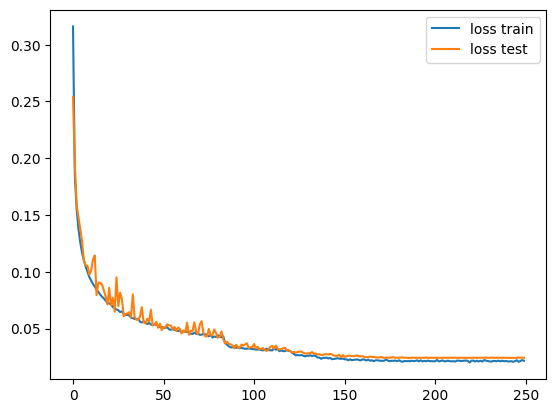

In [14]:
train_a_model(model,train_loader,Gau,test_set,epochs = epochs,lr=1e-3,outmodelname='../models/C2_flyshift3.pkl')

              precision    recall  f1-score   support

           0      0.993     0.991     0.992     18118
           1      0.830     0.836     0.833       556
           2      0.957     0.960     0.959      1448
           3      0.818     0.858     0.837       162
           4      0.988     0.991     0.990      1608

    accuracy                          0.984     21892
   macro avg      0.917     0.927     0.922     21892
weighted avg      0.984     0.984     0.984     21892



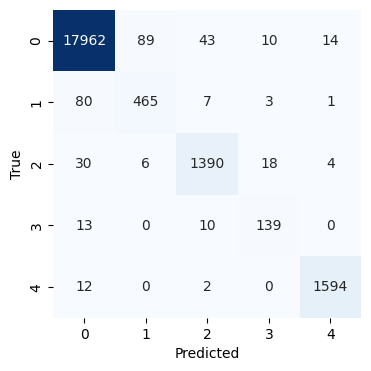

In [9]:
model_1=joblib.load('../models/C2_flyshift.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model_1, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

### kernels

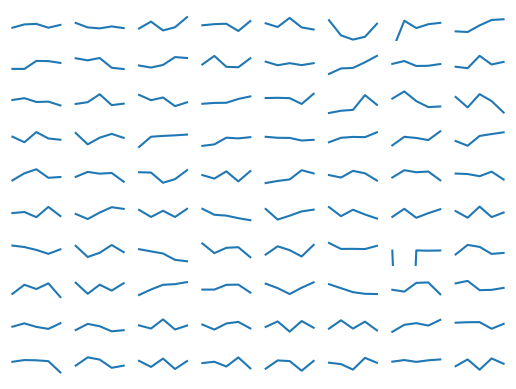

In [13]:
layer1 = model_1[0]
N = layer1.weight.shape[0]
fig,ax = plt.subplots(nrows=10,ncols=8)
ax =ax.flatten()
for k in range(min(N,80)):
    ax[k].plot(layer1.weight[k,0,:].detach().numpy())
    ax[k].set_axis_off()
    ax[k].set_ylim([-2,2])